In [1]:
import geopandas as gpd
import pandas as pd
import networkx as nx
import osmnx as ox
import contextily as cx
import numpy as np
import joblib
import math
from pyrosm import OSM, get_data
import matplotlib.pyplot as plt
from shapely import Point
from descartes import PolygonPatch
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.spatial.distance import cdist
from osmium.geom import haversine_distance
import osmium

In [2]:
data_folder = "./openstreetmap data/"
osm_fp = "./openstreetmap data/porto.osm.pbf"
osm = OSM(osm_fp)

In [3]:
scenario = "rosa_circular"

# load the graph
porto_nodes = gpd.read_file(data_folder + f"porto_nodes_{scenario}.gpkg") # TROCAR EM FUNÇÃO DO CENÁRIO
porto_edges = gpd.read_file(data_folder + f"porto_edges_{scenario}.gpkg")

porto_nodes.crs = "EPSG:4326"
porto_edges.crs = "EPSG:4326"


# G = osm.to_graph(porto_nodes, porto_edges2, graph_type='networkx', node_id_col='osmid', network_type='all')
G = osm.to_graph(porto_nodes, porto_edges, graph_type='networkx', node_id_col='osmid', network_type='driving')

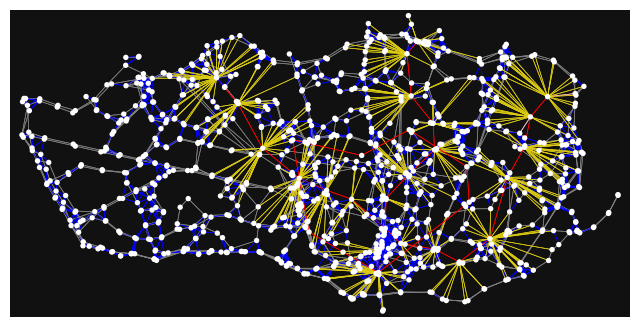

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [4]:
ox.plot_graph(G, edge_color=['#ddcc11' if d.get('tag') == 'bus_nearest_metro' else 'pink' if d.get('tag') == 'metro_nearest_bus' else 'blue' if d.get('mode')=='walking' else 'red' if d.get('mode')=='metro' else 'gray' for u,v,d in G.edges(data=True)], edge_linewidth=0.5)

In [5]:
{node: (data['y'], data['x'])  # (lat, lon)
                      for node, data in G.nodes(data=True)}

{'1ADA1': (41.1716440199193, -8.61355552858081),
 '1AL2': (41.1495147366521, -8.6100690279121),
 '1AL6': (41.1491175343024, -8.6100096776489),
 '1BS2': (41.155925167507, -8.62776236753369),
 '1BS3': (41.1544711389856, -8.62820614222973),
 '1DBR1': (41.1498620598388, -8.61763800660253),
 '1MGB1': (41.1497565574623, -8.62029347012526),
 '1R9A1': (41.1701170139347, -8.61785894732277),
 '1SBNT': (41.1448596662601, -8.61083698086075),
 'A25A1': (41.1555277896634, -8.58608327383168),
 'AA1': (41.1788015511771, -8.58399453457246),
 'AA2': (41.1788917537325, -8.58413721443805),
 'AAL1': (41.1489444244748, -8.61127779731674),
 'AAL2': (41.1488184731304, -8.61047208496171),
 'AAL4': (41.1485277270248, -8.61066664214757),
 'AAL5': (41.1482143139209, -8.61068211157332),
 'AALB': (41.1588150642884, -8.6623307525236),
 'AANT1': (41.1627120138617, -8.58601669995918),
 'AANT2': (41.1631943937472, -8.58580556145573),
 'AANT5': (41.163200050617, -8.58340391200963),
 'ABM1': (41.1671944068014, -8.6546111

# Add edges

In [6]:
def add_walking(G):
    # Create a copy of the original graph to preserve it
    new_G_with_walking = G.copy()
    # Count original edges
    original_edges = G.number_of_edges()
    # Maximum walking distance in meters
    MAX_WALKING_DISTANCE = 300
    WALKING_SPEED = 1.2  # meters per second (about 5 km/h)
    # Get node positions
    node_positions = {node: (data['y'], data['x'])  # (lat, lon)
                      for node, data in G.nodes(data=True)}
    # Add a progress counter
    # total_nodes = len(G.nodes())
    # processed_nodes = 0
    walking_edges_added = 0
    for node1 in G.nodes():
        pos1 = node_positions[node1]  # (lat, lon)

        for node2 in G.nodes():
            if node1 != node2:
                pos2 = node_positions[node2]  # (lat, lon)

                # Calculate actual distance in meters
                # first convert pos1 and pos2 to osmium geom.Coordinates
                pos1_ = osmium.geom.Coordinates(pos1[1], pos1[0])
                pos2_ = osmium.geom.Coordinates(pos2[1], pos2[0])
                distance = haversine_distance(pos1_, pos2_)

                if distance <= MAX_WALKING_DISTANCE and not new_G_with_walking.has_edge(node1, node2):
                    new_G_with_walking.add_edge(node1, node2,
                                            length=distance,
                                            travel_time_seconds=distance / WALKING_SPEED,
                                            mode='walking')
                    walking_edges_added += 1
                    
    return new_G_with_walking


In [47]:
G_connected = G.copy()
G_metro_only = G.copy()
stcp_nodes = porto_nodes[porto_nodes['tags'] == 'bus']

G_metro_only.remove_nodes_from(stcp_nodes['id'].values)
nearest_node = ox.distance.nearest_nodes(G_metro_only, X=-8.613556, Y=41.171644, return_dist=True)
nearest_node

('6005', 813.0232655041132)

In [7]:
def connect_metro_to_nearest_bus(G, metro_nodes, walking_speed=1.2, tag='metro_nearest_bus'):
    """
    Connects each metro station to its nearest bus stop with walking edges.
    
    Args:
        G (networkx.Graph): Original graph containing both metro and bus nodes
        metro_nodes (pandas.DataFrame): DataFrame containing metro node information with 'id', 'lat', 'lon' columns
        walking_speed (float): Walking speed in meters per second (default 1.2 m/s ≈ 4.32 km/h)
        tag (str): Tag to identify the added walking edges
        
    Returns:
        networkx.Graph: Graph with added walking connections between metro and nearest bus stops
    """
    G_connected = G.copy()
    G_bus_only = G.copy()
    G_bus_only.remove_nodes_from(metro_nodes['id'].values)
    
    new_edges = 0
    
    for _, metro_node in metro_nodes.iterrows():
        # Find nearest bus stop
        nearest_bus, _ = ox.distance.nearest_nodes(
            G_bus_only, 
            X=metro_node['x'], 
            Y=metro_node['y'], 
            return_dist=True
        )
        
        # Calculate walking distance
        metro_pos = osmium.geom.Coordinates(metro_node['x'], metro_node['y'])
        bus_pos = osmium.geom.Coordinates(
            G.nodes[nearest_bus]['x'],
            G.nodes[nearest_bus]['y']
        )
        distance = haversine_distance(metro_pos, bus_pos)
        
        # Add bidirectional walking edges
        edge_attrs = {
            'length': distance,
            'travel_time_seconds': distance / walking_speed,
            'mode': 'walking',
            'tag': tag
        }
        
        for source, target in [(nearest_bus, metro_node['id']), (metro_node['id'], nearest_bus)]:
            if not G_connected.has_edge(source, target):
                G_connected.add_edge(source, target, **edge_attrs)
                new_edges += 1
    
    print(f"Added {new_edges} walking edges between metro stations and nearest bus stops")
    return G_connected

In [48]:
def connect_bus_to_nearest_metro(G, bus_nodes, metro_to_bus_distance=1200, bus_to_metro_distance=300, walking_speed=1.2, tag='bus_nearest_metro'):
    """
    Connects bus stops to nearby metro stations with walking edges, using different distance thresholds
    for metro-to-bus and bus-to-metro connections.
    
    Args:
        G (networkx.Graph): Original graph containing both metro and bus nodes
        bus_nodes (pandas.DataFrame): DataFrame containing bus node information with 'id', 'y', 'x' columns
        metro_to_bus_distance (float): Maximum walking distance from metro to bus stops in meters
        bus_to_metro_distance (float): Maximum walking distance from bus to metro stops in meters
        walking_speed (float): Walking speed in meters per second
        tag (str): Tag to identify the added walking edges
        
    Returns:
        networkx.Graph: Graph with added walking connections between bus stops and nearby metro stations
    """
    G_connected = G.copy()
    G_metro_only = G.copy()
    G_metro_only.remove_nodes_from(bus_nodes['id'].values)
    # print(f"Nodes in G_metro_only: {len(G_metro_only.nodes())}")
    # print(f"Nodes in G_connected: {len(G_connected.nodes())}")
    # print(f"Nodes in bus_nodes: {len(bus_nodes)}")
    
    new_edges = 0
    errors = 0
    
    for _, bus_node in bus_nodes.iterrows():
        # Find nearest metro station
        # try:
        print(type(bus_node['x']), bus_node['y'])
        nearest_metro, _ = ox.distance.nearest_nodes(
            G_metro_only,
            X=-8.567,
            Y=41.167,
            return_dist=True
        )
    # except Exception as e:
        # print(bus_node)
        # print(f"Error finding nearest metro for bus stop {bus_node['id']}: {e}")
        errors += 1
            # continue
        
        # Calcuye walking distance
        bus_pos = osmium.geom.Coordinates(bus_node['x'], bus_node['y'])
        metro_pos = osmium.geom.Coordinates(
            G.nodes[nearest_metro]['x'],
            G.nodes[nearest_metro]['y']
        )
        distance = haversine_distance(bus_pos, metro_pos)
        
        edge_attrs = {
            'length': distance,
            'travel_time_seconds': distance / walking_speed,
            'mode': 'walking',
            'tag': tag
        }
        
        # Add bus-to-metro edge (longer distance allowed)
        if (distance <= metro_to_bus_distance and 
            not G_connected.has_edge(bus_node['id'], nearest_metro)):
            G_connected.add_edge(bus_node['id'], nearest_metro, **edge_attrs)
            new_edges += 1
        
        # Add metro-to-bus edge (shorter distance threshold)
        if (distance <= bus_to_metro_distance and 
            not G_connected.has_edge(nearest_metro, bus_node['id'])):
            G_connected.add_edge(nearest_metro, bus_node['id'], **edge_attrs)
            new_edges += 1
    
    print(f"Added {new_edges} walking edges between bus stops and nearby metro stations")
    print(f"Errors: {errors}")
    return G_connected

In [31]:
G_with_walking = add_walking(G)
metro_nodes = porto_nodes[porto_nodes['tags'] == 'metro']
G_metro_connected = connect_metro_to_nearest_bus(G_with_walking, metro_nodes)
stcp_nodes = porto_nodes[porto_nodes['tags'] == 'bus']

Added 2 walking edges between metro stations and nearest bus stops


In [49]:
G_bus_connected = connect_bus_to_nearest_metro(
    G_metro_connected, 
    stcp_nodes,
    metro_to_bus_distance=1200,  # people may walk further to reach metro
    bus_to_metro_distance=300    # standard walking distance
)

<class 'float'> 41.1716440199193


ValueError: Input contains NaN.

In [ ]:
ox.plot_graph(G_with_walking, edge_color=['#ddcc11' if d.get('tag') == 'bus_nearest_metro' else 'pink' if d.get('tag') == 'metro_nearest_bus' else 'blue' if d.get('mode')=='walking' else 'red' if d.get('mode')=='metro' else 'gray' for u,v,d in G_with_walking.edges(data=True)], edge_linewidth=0.5)


In [ ]:
ox.plot_graph(G_bus_connected, edge_color=['#ddcc11' if d.get('tag') == 'bus_nearest_metro' else 'pink' if d.get('tag') == 'metro_nearest_bus' else 'blue' if d.get('mode')=='walking' else 'red' if d.get('mode')=='metro' else 'gray' for u,v,d in G_bus_connected.edges(data=True)], edge_linewidth=0.5)

In [ ]:
G = G_bus_connected

## Sections

In [ ]:
sections = gpd.read_file(data_folder + "sections.gpkg")
# sections.crs = "EPSG:4326"
sections.rename(columns={'DTMNFRSEC21': 'id'}, inplace=True)

sections = sections.to_crs("EPSG:4326")
sections['centroid'] = sections['geometry'].centroid

In [ ]:
# ax = sections.plot("N_INDIVIDUOS", scheme="natural_breaks", cmap="Reds", figsize=(12,12), legend=True, markersize=3.5)
# cx.add_basemap(ax, crs=sections.crs)

In [ ]:
amenities = "bar, cafe, fast_food, food_court, restaurant, college, dancing_school, driving_school, kindergarten, library, research_institute, music_school, school, university, fuel, bank, clinic, dentist, hospital, nursing_home, pharmacy, veterinary, arts_centre, cinema, community_centre, conference_centre, events_venue, exhibition_centre, music_venue, nightclub, theatre, police, post_office, townhall, animal_shelter, marketplace"

amenities = amenities.split(", ")

sections_union = sections.unary_union
# sections_union.to_crs("EPSG:4326")
sections_gdf = gpd.GeoDataFrame(geometry=[sections_union], crs="EPSG:4326")

amenities_gdf = ox.features_from_polygon(sections.unary_union, tags={'amenity': amenities})

amenities_gdf['geometry'] = amenities_gdf.centroid

sections_amenities = gpd.sjoin(sections, amenities_gdf, predicate='contains')

# have a dictionary with the amenities and the sections they are in
amenities_dict = {}
for i, row in sections_amenities.iterrows():
    if row.id not in amenities_dict:
        amenities_dict[row.id] = []
    amenities_dict[row.id].append(row.amenity)
    
amenities_count = {}
for k, v in amenities_dict.items():
    amenities_count[k] = len(v)
    
#add the amenities count to the sections
sections["N_AMENITIES"] = sections.id.map(amenities_count)
sections["N_AMENITIES_LOG"] = sections.id.map(amenities_count).apply(lambda x: math.log(x+1))

## Amenities = tipos de espaços

In [ ]:
# plot a heatmap, log scale
# ax = sections.plot("N_AMENITIES_LOG", scheme="natural_breaks", cmap="Reds", figsize=(12,12), legend=True, markersize=3.5)
# cx.add_basemap(ax, crs=sections.crs)

In [ ]:
# floyd warshall algorithm
pred, dist = nx.floyd_warshall_predecessor_and_distance(G, weight='travel_time_seconds')

In [ ]:
# compute the average times using G
# average_distances = {}

nearest_nodes = {} # reyive to sections
for section in sections['id']:
    section_centroid = sections.loc[sections['id'] == section, 'centroid']
    nearest_nodes[section] = ox.distance.nearest_nodes(G, X=section_centroid.x.values[0], Y=section_centroid.y.values[0])
    # average_distances[section] = np.mean([dist[nearest_nodes[section]][nearest_nodes[other]] for other in sections['id']])

average_times = {}

# first get a matrix of the distances and paths between the nearest nodes
nearest_node_times = np.zeros((len(sections), len(sections)))
nearest_node_paths = {}

for i, section1 in enumerate(sections['id']):
    for j, section2 in enumerate(sections['id']):
        nearest_node_times[i, j] = dist[nearest_nodes[section1]][nearest_nodes[section2]]
        nearest_node_paths[(section1, section2)] = nx.reconstruct_path(nearest_nodes[section1], nearest_nodes[section2], pred)

# get the average time between each section and all the others
for section1 in sections['id']:
    # row mean
    average_times[section1] = np.mean(nearest_node_times[sections['id'] == section1])
    
sections['average_time'] = sections['id'].map(average_times)

In [ ]:
class SpatialInteractionModel:
    def __init__(self, sections_gdf, amenities_gdf, sections_amenities):
        """
        Initialize the spatial interaction model
        
        Parameters:
        sections_gdf: GeoDataFrame with section demographics and geometries
        amenities_gdf: GeoDataFrame with amenity points and types
        sections_amenities: dict mapping section_id to list of amenity types
        """
        self.sections_gdf = sections_gdf.copy().to_crs("EPSG:3763")
        self.amenities_gdf = amenities_gdf.copy().to_crs("EPSG:3763")
        self.sections_amenities = sections_amenities.copy()
        
        # Calculate centroids for distance matrix
        self.centroids = self.sections_gdf.geometry.centroid
        # self.distances = self._calculate_distance_matrix()
        self.distances = nearest_node_times
        
        # Create amenity counts per section
        self.amenity_counts = self._calculate_amenity_counts()
    
    def calculate_distance_matrix(self):
        """Calculate distance matrix between all section centroids"""
        coords = np.column_stack([
            self.centroids.x.values,
            self.centroids.y.values
        ])
        return cdist(coords, coords)
    
    def _calculate_amenity_counts(self):
        """Calculate counts of each amenity type per section"""
        amenity_counts = pd.DataFrame(
            index=self.sections_gdf['id'],
            columns=self.amenities_gdf['amenity'].unique(),
            data=0
        )
        
        
        for section_id, amenities in self.sections_amenities.items():
            if section_id in amenity_counts.index:
                for amenity_type in amenities:
                    if amenity_type in amenity_counts.columns:
                        amenity_counts.loc[section_id, amenity_type] += 1
        
        return amenity_counts
    
    def gravity_model(self, origin_pop, destination_attr, alpha=1, beta=0.2, normalize=True):
        """
        Calculate trip probabilities using a gravity model
        
        Parameters:
        origin_pop: Array of origin population values
        destination_attr: Array of destination attractiveness values
        alpha: Population exponent parameter
        beta: Distance decay parameter
        """
        # Avoid division by zero
        distances = np.maximum(self.distances, 0.1)
        # distances is in meters, sometimes hundreds or thousands, convert to km
        distances = distances / 1000
        
        # Calculate flows
        flows = (origin_pop.reshape(-1, 1) ** alpha) * \
                (destination_attr.reshape(1, -1)) / \
                (distances ** beta)
        if not normalize:
            return flows
        # Normalize to get probabilities
        row_sums = flows.sum(axis=1, keepdims=True)
        row_sums = np.where(row_sums == 0, 1, row_sums)  # Avoid division by zero
        return flows / row_sums
    
    
    def education_trips(self, normalize=True):
        """Model education-related trips"""
        # Different education segments
        students_0_14 = self.sections_gdf['N_INDIVIDUOS_0A14'].values
        students_15_24 = self.sections_gdf['N_INDIVIDUOS_15A24'].values
        
        # Calculate education attractiveness
        education_attractiveness = (
            self.amenity_counts['school'].values * 1.0 +
            self.amenity_counts['college'].values * 1.5 +
            self.amenity_counts['university'].values * 2.0 +
            self.amenity_counts['library'].values * 0.5
        )
        
        # Calculate trips for different age groups
        young_trips = self.gravity_model(
            students_0_14,
            education_attractiveness,
            beta=0.5,  # Higher decay for younger students
            normalize=normalize
        )
        
        older_trips = self.gravity_model(
            students_15_24,
            education_attractiveness,
            beta=0.5,  # Lower decay for older students
            normalize=normalize
        )
        
        return {
            'young_education': young_trips,
            'older_education': older_trips
        }
    
    def work_trips(self, normalize=True):
        """Model work-related trips"""
        workers = self.sections_gdf['N_INDIVIDUOS_EMPREGADOS'].values
        
        # Use employment by sector as attractiveness
        job_attractiveness = (
            self.sections_gdf['N_INDIVIDUOS_EMPREG_SECT_PRIM'].values * 0.8 +
            self.sections_gdf['N_INDIVIDUOS_EMPREG_SECT_SEC'].values * 1.0 +
            self.sections_gdf['N_INDIVIDUOS_EMPREG_SECT_TERC'].values * 1.2
        )
        
        return self.gravity_model(
            workers,
            job_attractiveness,
            beta=0.5,
            normalize=normalize
        )
    
    def entertainment_trips(self, normalize=True):
        """Model entertainment-related trips"""
        young_adults = self.sections_gdf['N_INDIVIDUOS_15A24'].values
        adults = self.sections_gdf['N_INDIVIDUOS_25A64'].values
        
        # Calculate entertainment attractiveness
        day_entertainment = (
            self.amenity_counts['cafe'].values * 1.0 +
            self.amenity_counts['restaurant'].values * 1.2 +
            self.amenity_counts['cinema'].values * 1.5 +
            self.amenity_counts['arts_centre'].values * 0.8 +
            self.amenity_counts['theatre'].values * 1.0
        )
        
        night_entertainment = (
            self.amenity_counts['bar'].values * 1.2 +
            self.amenity_counts['nightclub'].values * 1.5
            # self.amenity_counts['music_venue'].values * 1.3
        )
        
        return {
            'day_trips': self.gravity_model(
                adults * 0.6 + young_adults * 0.4,
                day_entertainment,
                beta=0.5,
                normalize=normalize
            ),
            'night_trips': self.gravity_model(
                adults * 0.3 + young_adults * 0.7,
                night_entertainment,
                beta=0.5,
                normalize=normalize
            )
        }
    
    def healthcare_trips(self, normalize=True):
        """Model healthcare-related trips"""
        elderly = self.sections_gdf['N_INDIVIDUOS_65_OU_MAIS'].values
        adults = self.sections_gdf['N_INDIVIDUOS_25A64'].values
        young = self.sections_gdf['N_INDIVIDUOS_0A14'].values
        
        basic_healthcare = (
            self.amenity_counts['clinic'].values * 1.0 +
            self.amenity_counts['pharmacy'].values * 0.8 +
            self.amenity_counts['dentist'].values * 0.9
        )
        
        specialized_healthcare = (
            self.amenity_counts['hospital'].values * 2.0 +
            self.amenity_counts['nursing_home'].values * 0.7
        )
        
        return {
            'basic_healthcare': self.gravity_model(
                elderly * 1.5 + adults + young * 1.2,
                basic_healthcare,
                beta=0.5,
                normalize=normalize
            ),
            'specialized_healthcare': self.gravity_model(
                elderly * 2.0 + adults + young,
                specialized_healthcare,
                beta=0.5,
                normalize=normalize
            )
        }
    
    def shopping_trips(self, normalize=True):
        """
        Model shopping-related trips
        """
        # Shopping population (adults and elderly)
        shoppers = (
            self.sections_gdf['N_INDIVIDUOS_25A64'].values +
            self.sections_gdf['N_INDIVIDUOS_65_OU_MAIS'].values * 0.8
        )
        
        # Shopping attractiveness
        shopping_attractiveness = (
            self.amenity_counts['marketplace'].values * 1.5 +
            self.amenity_counts['food_court'].values * 1.2
        )
        
        return {
            'daily_shopping': self.gravity_model(
                shoppers,
                shopping_attractiveness,
                beta=0.5,  # Daily shopping tends to be local,
                normalize=normalize
            ),
            'leisure_shopping': self.gravity_model(
                shoppers,
                shopping_attractiveness,
                beta=0.5,  # People might travel further for leisure shopping,
                normalize=normalize
            )
        }
    
    def administrative_trips(self, normalize=True):
        """
        Model trips to administrative services
        """
        # Adult population
        adults = (
            self.sections_gdf['N_INDIVIDUOS_25A64'].values +
            self.sections_gdf['N_INDIVIDUOS_65_OU_MAIS'].values
        )
        
        # Administrative services attractiveness
        admin_attractiveness = (
            self.amenity_counts['post_office'].values * 1.0 +
            self.amenity_counts['bank'].values * 1.2 +
            self.amenity_counts['townhall'].values * 1.5
        )
        
        return self.gravity_model(
            adults,
            admin_attractiveness,
            beta=0.5,  # Administrative trips are usually to nearby services
            normalize=normalize
        )
    
    def overall_trips(self):
        """
        Model overall trip "demands" between each section
        """
        
        # calculate unnormalized trips for each category, then sum them with different weights
        education_trips = self.education_trips(normalize=False)
        work_trips = self.work_trips(normalize=False)
        entertainment_trips = self.entertainment_trips(normalize=False)
        healthcare_trips = self.healthcare_trips(normalize=False)
        shopping_trips = self.shopping_trips(normalize=False)
        administrative_trips = self.administrative_trips(normalize=False)
        
        weights = {
            'education': 2.0,
            'work': 1.5, # usage of car?
            'entertainment': 1.0,
            'healthcare': 1.5,
            'shopping': 1.0,
            'administrative': 0.8
        }
            
        overall_trips = (
            education_trips['young_education'] * weights['education'] + \
            education_trips['older_education'] * weights['education'] + \
            work_trips * weights['work'] + \
            entertainment_trips['day_trips'] * weights['entertainment'] + \
            entertainment_trips['night_trips'] * weights['entertainment'] + \
            healthcare_trips['basic_healthcare'] * weights['healthcare'] + \
            healthcare_trips['specialized_healthcare'] * weights['healthcare'] + \
            shopping_trips['leisure_shopping'] * weights['shopping'] + \
            shopping_trips['daily_shopping'] * weights['shopping'] + \
            administrative_trips * weights['administrative']         
        )
        
        return overall_trips
        



Este modelo conta para cada secção quantas amenities há de cada tipo e calcula o número de amenities relevantes para cada "necessidade de viagem" (educação, saúde, etc.) e calcula a probabilidade de viagem entre cada secção e as outras secções. Ex: as amenities relevantes para saúde são "hospital" e "clinic", cria-se uma matriz em que M_ij é a população de um determinado grupo (indívduos 5 a 24 anos, por exemplo) de i multiplicada pelo número de amenities de j dividido pela distância entre i e j elevada a um expoente beta. A matriz é normalizada para obter probabilidades de viagem.

In [ ]:
model = SpatialInteractionModel(sections, amenities_gdf, amenities_dict)
overall_trips = model.overall_trips()
np.fill_diagonal(overall_trips, 0.0)

In [ ]:
# demora 1min a correr

top_10_destinations_by_origin = pd.DataFrame(columns=['section_id', 'origin_x', 'origin_y', 'dest_x', 'dest_y', 'dest_section_id', 'trip_flow'])

# Iterate over each origin section
for origin_id in range(overall_trips.shape[0]):
    section_id = sections['id'].values[origin_id]
    origin_coords = sections.loc[sections['id'] == section_id].geometry.centroid
    
    # Get the top 10 destinations for the current origin
    top_destinations = np.argsort(overall_trips[origin_id])[-5:][::-1]
    
    # Add rows for each top destination
    for dest_id in top_destinations:
        dest_section_id = sections['id'].values[dest_id]
        dest_coords = sections.loc[sections['id'] == dest_section_id].geometry.centroid
        trip_flow = overall_trips[origin_id, dest_id]
        
        top_10_destinations_by_origin = pd.concat(
            [
                pd.DataFrame(
                [
                    [
                    section_id,
                    origin_coords.x.values[0],
                    origin_coords.y.values[0],
                    dest_coords.x.values[0],
                    dest_coords.y.values[0],
                    dest_section_id,
                    trip_flow,                    
                    ],
                ], 
                columns=top_10_destinations_by_origin.columns
                ),
                top_10_destinations_by_origin,
            ],
            ignore_index=True           
        )

In [ ]:
#store as json
top_10_destinations_by_origin.to_json(f"top_10_destinations_by_origin_{scenario}.json", indent=2, orient="records")

O resultado foi este (visto em kepler.gl). São os top 10 destinos de viagens para cada secção. A cor e espessura das linhas representam uma intensidade meio proporcional ao númeor de viagens.
A maior parte das viagens é para muito perto, o que faz sentido, mas não é interessante, será uma questão de ajustar o modelo.

![1](imagens/kepler.gl.png)

![2](imagens/kepler.gl_topo.png)

In [ ]:
# Calculate different types of trips
# education_trips = model.education_trips()
# work_trips = model.work_trips()
# entertainment_trips = model.entertainment_trips()
# healthcare_trips = model.healthcare_trips()

# The returned values are probability matrices where:
# - Rows represent origin sections
# - Columns represent destination sections
# - Values represent the probability of trips between those sections

# Example: Get top 3 destinations for education trips from section 0
# young_education_probs = education_trips['young_education']
# top_destinations = np.argsort(young_education_probs[0])[-3:][::-1]


# Simulation?

In [ ]:
# load top_10_destinations_by_origin3.json
# top_10_destinations_by_origin = pd.read_json(f"top_10_destinations_by_origin_{scenario}.json")

In [ ]:
top_10_destinations_by_origin['distance'] = top_10_destinations_by_origin.apply(lambda x: haversine_distance(
    osmium.geom.Coordinates(x.origin_y, x.origin_x), osmium.geom.Coordinates(x.dest_y, x.dest_x)), axis=1)
summed_trip_flows = top_10_destinations_by_origin.groupby('section_id')['trip_flow'].sum()
# add a column with the normalized (0 to 1) trip_flow per section
top_10_destinations_by_origin['trip_flow_n'] = top_10_destinations_by_origin.apply(
    lambda x: x.trip_flow / summed_trip_flows[x.section_id], axis=1)

# the number of trips is proportional to the trip_flow
for i, row in top_10_destinations_by_origin.iterrows():
    section_id = str(int(row.section_id))
    section_population = sections.loc[sections['id'] == section_id, 'N_INDIVIDUOS'].values[0]
    section_trip_freq = int(section_population / 20)

    trips = np.random.choice([0, 1], size=section_trip_freq, p=[1 - row.trip_flow_n, row.trip_flow_n])
    top_10_destinations_by_origin.at[i, 'trips'] = trips.sum()
    
# top_10_destinations_by_distance = top_10_destinations_by_origin.groupby('section_id').apply(lambda x: x.nlargest(10, 'distance')).reset_index(drop=True)
# summed_trip_flows = top_10_destinations_by_distance.groupby('section_id')['trip_flow'].sum()
# top_10_destinations_by_distance['trip_flow_n'] = top_10_destinations_by_distance.apply(lambda x: x.trip_flow / summed_trip_flows[x.section_id], axis=1)


In [ ]:
# simulate trips
# for i, row in top_10_destinations_by_distance.iterrows():
#     # trip_flow is currently unbounded
#     section_id = str(int(row.section_id))
#     section_population = sections.loc[sections['id'] == section_id, 'N_INDIVIDUOS'].values[0]
#     section_trip_freq = int(section_population / 20)
#     
#     trips = np.random.choice([0, 1], size=section_trip_freq, p=[1-row.trip_flow_n, row.trip_flow_n])
#     top_10_destinations_by_distance.at[i, 'trips'] = trips.sum()
#     

---

---
---
# N

## Linhas isócronas

In [ ]:
trip_times = [2, 6, 10, 15, 20] #in minutes
# mult by 60 to convert to seconds
trip_times = [60 * t for t in trip_times]
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)
# find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
center_node = ox.nearest_nodes(G, x[0], y[0])
G_projected = ox.project_graph(G)

In [ ]:
def edge_colors(G, alpha=1, attr='mode'):
    alpha_hex = str(hex(int(255*alpha)))[2:]
    return ['#999999' + alpha_hex if (d.get(attr) == 'metro' or d.get(attr)[0].isnumeric()) else '#ffffff00' for u,v,d in G.edges(data=True)]

In [ ]:
# color the nodes according to isochrone then plot the street network
# node_colors = {}
# for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
#     subgraph = nx.ego_graph(G_projected, center_node, radius=trip_time, distance='travel_time_seconds')
#     for node in subgraph.nodes():
#         node_colors[node] = color
# nc = [node_colors[node] if node in node_colors else 'none' for node in G_projected.nodes()]
# ns = [15 if node in node_colors else 0 for node in G_projected.nodes()]
# # dont plot edges with mode different from metro or bus
# fig, ax = ox.plot_graph(G_projected, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2,
#                         bgcolor='k', edge_linewidth=0.2, edge_color=edge_colors(G_projected))

In [ ]:

# make the isochrone polygons
# isochrone_polys = []
# for trip_time in sorted(trip_times, reverse=True):
#     subgraph = nx.ego_graph(G_projected, center_node, radius=trip_time, distance='travel_time_seconds')
#     node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
#     bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
#     isochrone_polys.append(bounding_poly)

In [ ]:
# # plot the network then add isochrones as colored descartes polygon patches
# fig, ax = ox.plot_graph(G_projected, show=False, close=False, edge_color=edge_colors(G_projected, alpha=0.4),
#                         node_size=0, bgcolor='k', node_zorder=-1)
# for polygon, fc in zip(isochrone_polys, iso_colors):
#     # print(polygon)
#     patch = PolygonPatch(polygon.__geo_interface__, fc=fc, ec='none', alpha=0.6)
#     ax.add_patch(patch)
# plt.show()

In [ ]:
center_node

In [ ]:
from shapely import Polygon, LineString

def make_iso_polys(G, center, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center, radius=trip_time, distance='travel_time_seconds')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        
        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

isochrone_polys = make_iso_polys(G_projected, 'PLM2',  edge_buff=25, node_buff=0, infill=False)
fig, ax = ox.plot_graph(G_projected, show=False, close=False, edge_color=edge_colors(G_projected, 0.2),
                        node_size=0, bgcolor='k')

for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon.__geo_interface__, fc=fc, ec='none', alpha=0.6, zorder=-1)
    ax.add_patch(patch)

plt.show()

In [ ]:
# plot heatmap of average times
ax = sections.plot("average_time", cmap="Reds", figsize=(12,12), legend=True, markersize=3.5)

---

In [ ]:
def calculate_accessibility_metrics(sections, nearest_node_times):
    metrics = {}
    
    # Time-based accessibility
    time_thresholds = [600, 1200, 1800]  # 10, 20, 30 minutes
    
    for section in sections['id']:
        metrics[section] = {
            f'reachable_sections_{t/60}min': len([other for other in sections['id'] 
                if nearest_node_times[sections['id'] == section, sections['id'] == other] < t])
            for t in time_thresholds
        }
        
        # Add average time to all other sections
        metrics[section]['avg_time_to_others'] = np.mean(
            nearest_node_times[sections['id'] == section])
        
        # Add population-weighted accessibility
        metrics[section]['population_weighted_access'] = np.sum([
            sections.loc[sections['id'] == other, 'N_INDIVIDUOS'].values[0] /
            (nearest_node_times[sections['id'] == section, sections['id'] == other] + 1)
            for other in sections['id']
        ])
    
    return pd.DataFrame.from_dict(metrics, orient='index')

In [ ]:
def calculate_activity_metrics(sections, model):
    metrics = {}
    
    for section in sections['id']:
        # Calculate activity potential based on amenities
        metrics[section] = {
            'education_potential': np.sum(model.education_trips()['young_education'][sections['id'] == section]),
            'work_potential': np.sum(model.work_trips()[sections['id'] == section]),
            'entertainment_potential': np.sum(model.entertainment_trips()['day_trips'][sections['id'] == section]),
            'healthcare_potential': np.sum(model.healthcare_trips()['basic_healthcare'][sections['id'] == section])
        }
        
        # Add combined score
        metrics[section]['activity_score'] = (
            metrics[section]['education_potential'] * 2.0 +
            metrics[section]['work_potential'] * 1.5 +
            metrics[section]['entertainment_potential'] * 1.0 +
            metrics[section]['healthcare_potential'] * 1.5
        )
    
    return pd.DataFrame.from_dict(metrics, orient='index')

In [ ]:
def analyze_network_gaps(sections, accessibility_metrics, activity_metrics):
    gaps = {}
    
    for section in sections['id']:
        population = sections.loc[sections['id'] == section, 'N_INDIVIDUOS'].values[0]
        
        # Calculate service level vs demand
        gaps[section] = {
            'population_density': population / sections.loc[sections['id'] == section, 'geometry'].area.values[0],
            'accessibility_score': accessibility_metrics.loc[section, 'population_weighted_access'],
            'activity_demand': activity_metrics.loc[section, 'activity_score']
        }
        
        # Calculate gap score (higher means bigger gap)
        gaps[section]['service_gap'] = (
            gaps[section]['population_density'] * 
            gaps[section]['activity_demand'] / 
            (gaps[section]['accessibility_score'] + 1)
        )
    
    return pd.DataFrame.from_dict(gaps, orient='index')

In [ ]:
def create_analysis_plots(sections, metrics):
    # Accessibility heatmap
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    sections.plot(column='accessibility_score', 
                 ax=ax1, 
                 cmap='YlOrRd',
                 legend=True,
                 legend_kwds={'label': 'Accessibility Score'})
    ax1.set_title('Transportation Accessibility')
    
    # Service gaps heatmap
    sections.plot(column='service_gap',
                 ax=ax2,
                 cmap='RdYlBu_r',
                 legend=True,
                 legend_kwds={'label': 'Service Gap Score'})
    ax2.set_title('Transportation Service Gaps')
    
    cx.add_basemap(ax1, crs=sections.crs)
    cx.add_basemap(ax2, crs=sections.crs)
    
    plt.tight_layout()
    plt.show()

---

In [ ]:
max_travel_time = 600  # 10 minutes in seconds
sectors_within_travel_time = {}
for section in sections['id']:
    sectors_within_travel_time[section] = np.sum(nearest_node_times[sections['id'] == section] < max_travel_time)

# Add to sections GeoDataFrame
sections['sectors_within_travel_time'] = sections['id'].map(sectors_within_travel_time)

# Plot heatmap
ax = sections.plot("sectors_within_travel_time", cmap="Reds", figsize=(12,12), alpha=0.6, legend=True, markersize=3.5)
ax.set_title('Number of sectors reachable within 10 minutes')
cx.add_basemap(ax, crs=sections.crs)

In [ ]:
# Compute betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G, weight='travel_time_seconds')

betweenness_centrality2 = {section: betweenness_centrality[nearest_nodes[section]] for section in sections['id']}
betweenness_centrality2

# Map centrality to sections
sections['betweenness_centrality'] = sections['id'].map(betweenness_centrality2)

# Plot heatmap
ax = sections.plot("betweenness_centrality", cmap="Reds", figsize=(12,12), legend=True, markersize=3.5)
ax.set_title('Betweenness centrality')
cx.add_basemap(ax, crs=sections.crs)

In [ ]:
# Compute closeness centrality
closeness_centrality = nx.closeness_centrality(G, distance='travel_time_seconds')
closeness_centrality2 = {section: closeness_centrality[nearest_nodes[section]] for section in sections['id']}


# Map centrality to sections
sections['closeness_centrality'] = sections['id'].map(closeness_centrality2)

# Plot heatmap
ax = sections.plot("closeness_centrality", cmap="Reds", figsize=(12,12), legend=True, markersize=3.5)
cx.add_basemap(ax, crs=sections.crs)

In [ ]:
eccentricity = nx.eccentricity(G, weight='travel_time_seconds')
eccentricity2 = {section: eccentricity[nearest_nodes[section]] for section in sections['id']}

# Map centrality to sections
sections['eccentricity'] = sections['id'].map(eccentricity2)

# Plot heatmap
ax = sections.plot("eccentricity", cmap="Reds", figsize=(12,12), legend=True, markersize=3.5)
cx.add_basemap(ax, crs=sections.crs)

In [ ]:
harmonic_centrality = nx.harmonic_centrality(G, distance='travel_time_seconds')
harmonic_centrality2 = {section: harmonic_centrality[nearest_nodes[section]] for section in sections['id']}

# Map centrality to sections
sections['harmonic_centrality'] = sections['id'].map(harmonic_centrality2)

# Plot heatmap
ax = sections.plot("harmonic_centrality", cmap="Reds", figsize=(12,12), legend=True, markersize=3.5)
cx.add_basemap(ax, crs=sections.crs)

## Mapa de acessibilidade


In [ ]:
def calculate_accessibility_score(sections, nearest_node_times, model):
    """
    Calculate accessibility scores for each section considering regular movement patterns
    
    Parameters:
    sections: GeoDataFrame with section demographics and geometries
    nearest_node_times: Matrix of travel times between sections
    model: SpatialInteractionModel instance with trip patterns
    
    Returns:
    GeoDataFrame with added accessibility scores
    """
    # Get different types of trips
    education_trips = model.education_trips(normalize=False)
    work_trips = model.work_trips(normalize=False)
    entertainment_trips = model.entertainment_trips(normalize=False)
    healthcare_trips = model.healthcare_trips(normalize=False)
    shopping_trips = model.shopping_trips(normalize=False)
    
    # Weights for different trip types based on frequency and importance
    weights = {
        'education': 2.0,  # Daily trips, high priority
        'work': 2.0,      # Daily trips, high priority
        'healthcare': 1.5, # Less frequent but critical
        'shopping': 1.0,   # Regular but flexible
        'entertainment': 0.5  # Optional, lower priority
    }
    
    accessibility_scores = {}
    
    for idx, section in enumerate(sections['id']):
        # Calculate weighted average time for each type of trip
        education_time = np.average(nearest_node_times[idx], 
                                  weights=(education_trips['young_education'][idx] + 
                                         education_trips['older_education'][idx]))
        
        work_time = np.average(nearest_node_times[idx], 
                             weights=work_trips[idx])
        
        healthcare_time = np.average(nearest_node_times[idx],
                                   weights=(healthcare_trips['basic_healthcare'][idx] + 
                                          healthcare_trips['specialized_healthcare'][idx]))
        
        shopping_time = np.average(nearest_node_times[idx],
                                 weights=(shopping_trips['daily_shopping'][idx] + 
                                        shopping_trips['leisure_shopping'][idx]))
        
        entertainment_time = np.average(nearest_node_times[idx],
                                      weights=(entertainment_trips['day_trips'][idx] + 
                                             entertainment_trips['night_trips'][idx]))
        
        # Combined accessibility score (lower is better - represents average weighted travel time)
        accessibility_scores[section] = (
            weights['education'] * education_time +
            weights['work'] * work_time +
            weights['healthcare'] * healthcare_time +
            weights['shopping'] * shopping_time +
            weights['entertainment'] * entertainment_time
        ) / sum(weights.values())
    
    # Add scores to sections DataFrame
    sections_copy = sections.copy()
    sections_copy['accessibility_score'] = sections_copy['id'].map(accessibility_scores)
    
    return sections_copy

def plot_accessibility(sections_with_scores, title="Accessibility Scores", cmap="RdYlBu_r"):
    """
    Plot accessibility scores on a map
    """
    fig, ax = plt.subplots(figsize=(15, 15))
    
    # Plot sections with accessibility scores
    sections_with_scores.plot(
        column='accessibility_score',
        cmap=cmap,
        legend=True,
        ax=ax,
        legend_kwds={
            'label': 'Average Weighted Travel Time (seconds)',
            'orientation': 'horizontal'
        }
    )
    
    # Add basemap
    cx.add_basemap(ax, crs=sections_with_scores.crs)
    
    # Add title
    plt.title(title, fontsize=16, pad=20)
    
    return fig, ax

In [ ]:
sections_with_accessibility = calculate_accessibility_score(sections, nearest_node_times, model)


In [ ]:
# fig, ax = plot_accessibility(sections_with_accessibility, title="Accessibility Scores")

# Não acho muito relevante ou fácil de explicar este

# Average Travel Times to Satisfy Regular needs


In [ ]:
# # add to top_10_destinations_by_origin, the dest_section_id. to do that, match the x and y coordinates from the centroid
# # since they are floats do a delta comparison
# top_10_destinations_by_origin['dest_section_id'] = top_10_destinations_by_origin.apply(
#     lambda x: sections[
#         ((sections['centroid'].x - x.dest_x).abs() < 0.0001) & 
#         ((sections['centroid'].y - x.dest_y).abs() < 0.0001)
#     ]['id'].values[0], 
#     axis=1
# )

In [ ]:
def calculate_weighted_travel_times(top_destinations_df, sections, nearest_node_times, pred):
    """
    Calculate average travel times weighted by number of trips for each section
    
    Parameters:
    top_destinations_df: DataFrame with columns section_id, dest_x, dest_y, trips
    sections: GeoDataFrame with section data
    nearest_node_times: Matrix of travel times between nodes
    pred: Predecessor matrix from floyd_warshall
    
    Returns:
    GeoDataFrame with weighted average travel times
    """
    weighted_times = {}
    
    # Group destinations by origin section
    grouped_destinations = top_destinations_df.groupby('section_id')
    
    for section_id, group in grouped_destinations:
        total_trips = group['trips'].sum()
        if total_trips == 0:
            weighted_times[section_id] = 0
            continue
            
        # Get origin index in the nearest_node_times matrix
        origin_idx = np.where(sections['id'] == str(int(section_id)))[0][0]

        # Calculate weighted travel time for this section
        weighted_time = 0
        for _, dest in group.iterrows():            
            if dest['trips'] == 0:
                continue               
            dest_idx = np.where(sections['id'] == str(int(dest.dest_section_id)))[0][0]
        
            # Get travel time between origin and destination
            # section where id column is the same as dest.section_id
            travel_time = nearest_node_times[origin_idx, dest_idx]
            
            # Add weighted contribution
            weighted_time += (travel_time * dest['trips'])
            
        # Calculate final weighted average
        # print(total_trips, weighted_time)
        weighted_times[section_id] = weighted_time / total_trips
    
    # Add to sections GeoDataFrame
    # print(weighted_times)
    sections_copy = sections.copy()
    # sections_copy['id'] = sect
    sections_copy['weighted_travel_time'] = sections_copy['id'].map(weighted_times)
    
    return sections_copy

def plot_weighted_times(sections_with_times, title="Average Travel Times Weighted by Trips"):
    """
    Plot weighted average travel times on a map
    """
    fig, ax = plt.subplots(figsize=(15, 15))
    
    # Plot sections with weighted times
    sections_with_times.plot(
        column='weighted_travel_time',
        cmap='RdYlBu_r',
        legend=True,
        vmin=0,
        vmax=700,
        ax=ax,
        legend_kwds={
            'label': 'Average Travel Time (seconds)',
            'orientation': 'horizontal'
        }
    )
    
    # Add basemap
    cx.add_basemap(ax, crs=sections_with_times.crs)
    
    # Add title
    plt.title(title, fontsize=16, pad=20)
    
    return fig, ax

In [ ]:
sections_with_weighted_times = calculate_weighted_travel_times(top_10_destinations_by_origin, sections, nearest_node_times, pred)

In [ ]:
plot_weighted_times(sections_with_weighted_times)

In [ ]:
porto_edges